<a href="https://colab.research.google.com/github/erickdiaz3010/tesis-network-analysis/blob/main/Thesis_VA_in_CA_Erick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting with Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# STEP 1 : Loading Input-Output Data and Setting Index for Sectoral Analysis
#This step loads all the necessary **Input-Output tables** from the Excel file and ensures that the `"code"` column is correctly set as the index.
# This process aligns sectoral data across different DataFrames to maintain consistency in later calculations.
# The key datasets include **Intermediate Consumption (`Z`), Gross Production (`T`), and Domestic Value Added (`C_df`)**.


import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load all sheets into a dictionary of DataFrames
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Standardize all DataFrames: Ensure 'code' is the index and remove extra 'code' column
for sheet_name, df in all_sheets.items():
    if 'code' in df.columns:
        df.set_index('code', inplace=True)  # Set 'code' as index
    # Ensure no extra 'code' column remains
    if 'code' in df.columns:
        df.drop(columns=['code'], inplace=True)
    all_sheets[sheet_name] = df  # Save changes back

print("✅ All DataFrames have been standardized with 'code' as index.")

# Extract DataFrames
Z = all_sheets.get('Intermediate_Consumption_Z')
T = all_sheets.get('Gross_Production_Value')
C_df = all_sheets.get('Domestic_Value_added')

# Debugging: Print initial shape
print("\n📊 Shapes after processing:")
for name, df in all_sheets.items():
    print(f"{name}: {df.shape}")

# Ensure correct columns
if 'Gross_Production_Value' in T.columns:
    T = T[['Gross_Production_Value']]  # Keep only the relevant column





✅ All DataFrames have been standardized with 'code' as index.

📊 Shapes after processing:
LAC_IOT_2014: (2205, 251)
original: (244, 251)
Intermediate_Consumption_Z: (240, 240)
Final_Demand_Intraregional: (240, 6)
Extra_Regional_Imports: (240, 37)
Production_Taxes: (240, 1)
Freight_Insurance: (240, 1)
Domestic_Value_added: (240, 1)
Gross_Production_Value: (240, 1)
Value_Added_Coefficients: (240, 2)
Degree_Networks: (240, 3)
Average Strength Metrics: (2, 3)
Degree Metrics by Sector: (240, 4)
In-Out Degree by Node: (240, 7)
In-Out Strength by Node: (240, 7)
Potential Flows by Edge: (50852, 2)
Circular Flows by Edge: (50852, 2)
Potential Flows with Sectors: (50852, 2)
Circular Flows with Sectors: (50852, 4)
Integration Index by Sector: (228, 5)


In [24]:
# STEP 2: Constructing the Adjacency Matrix (A) and Computing the Leontief Inverse Matrix (L).
# This step constructs the **Adjacency Matrix (A)**, which represents sectoral interdependencies based on **Intermediate Consumption (`Z`) and Gross Production (`T`)**.
# The matrix **A is used to compute the Leontief Inverse Matrix (L)**, which measures the total economic impact of demand shocks.
# The successful inversion of **(I - A)** ensures that the model is mathematically well-defined and can be used for economic impact analysis.

def create_adjacency_matrix(Z, T):
    """Compute the adjacency matrix A from Intermediate Consumption and Gross Production Value matrices."""

    # Ensure 'code' is the index
    if 'code' in Z.columns:
        Z.set_index('code', inplace=True)
    if 'code' in T.columns:
        T.set_index('code', inplace=True)

    # Ensure Z and T are aligned and square
    Z = Z.loc[Z.index.intersection(T.index), Z.columns.intersection(T.index)]
    T = T.loc[T.index.intersection(Z.index)]

    # Convert data to numeric
    Z = Z.apply(pd.to_numeric, errors='coerce')
    T['Gross_Production_Value'] = pd.to_numeric(T['Gross_Production_Value'], errors='coerce')

    # Extract the production vector and avoid division by zero
    T_vector = T['Gross_Production_Value'].fillna(1e-10).values
    epsilon = 1e-10
    T_vector = np.where(T_vector == 0, epsilon, T_vector)

    # Convert to matrix form
    Z_matrix = Z.fillna(0).values

    # Compute adjacency matrix A
    A_matrix = np.divide(Z_matrix, T_vector[:, np.newaxis], where=T_vector[:, np.newaxis] != 0)

    return pd.DataFrame(A_matrix, index=Z.index, columns=Z.columns)

# Generate adjacency matrix
A_df = create_adjacency_matrix(Z, T)

# Ensure matrix is square
A_df = A_df.loc[A_df.index.intersection(A_df.columns), A_df.columns.intersection(A_df.index)]

# Save adjacency matrix
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    A_df.to_excel(writer, sheet_name="Adjacency_Matrix")

print("✅ Adjacency matrix has been successfully saved.")







✅ Adjacency matrix has been successfully saved.


In [22]:
# Define the path to your Excel file
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load all sheets into a dictionary of DataFrames
sheets = pd.ExcelFile(file_path).sheet_names

# Print dimensions of all DataFrames
print("\n📊 DataFrames and their dimensions:\n")
for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet, index_col=0)
    print(f"{sheet}: {df.shape}")


📊 DataFrames and their dimensions:

LAC_IOT_2014: (2205, 250)
original: (244, 250)
Intermediate_Consumption_Z: (240, 240)
Final_Demand_Intraregional: (240, 6)
Extra_Regional_Imports: (240, 37)
Production_Taxes: (240, 1)
Freight_Insurance: (240, 1)
Domestic_Value_added: (240, 1)
Gross_Production_Value: (240, 1)
Value_Added_Coefficients: (240, 1)
Degree_Networks: (240, 2)
Average Strength Metrics: (2, 2)
Degree Metrics by Sector: (240, 3)
In-Out Degree by Node: (240, 6)
In-Out Strength by Node: (240, 6)
Potential Flows by Edge: (50852, 1)
Circular Flows by Edge: (50852, 1)
Potential Flows with Sectors: (50852, 1)
Circular Flows with Sectors: (50852, 1)
Integration Index by Sector: (228, 4)
Adjacency_Matrix: (240, 240)


In [25]:
print("Final shape of Adjacency Matrix before saving:", A_df.shape)

if A_df.empty:
    raise ValueError("❌ Error: Adjacency Matrix (A_df) is empty before saving. Check Step 2.")


Final shape of Adjacency Matrix before saving: (240, 240)


In [30]:
import pandas as pd

# Ruta del archivo
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Cargar solo la matriz de adyacencia
A_df = pd.read_excel(file_path, sheet_name="Adjacency_Matrix", index_col=0)

print("📊 Shape of Adjacency Matrix after loading:", A_df.shape)

# Verificar si la matriz está vacía
if A_df.empty:
    raise ValueError("❌ Error: Adjacency Matrix is empty after loading. Step 2 did not save it correctly.")


📊 Shape of Adjacency Matrix after loading: (240, 240)


In [31]:
print("✅ 'Adjacency_Matrix' loaded successfully.")
print("📊 Shape of A_df after loading:", A_df.shape)

# Revisar las primeras 5 columnas
print("🔍 First 5 columns:", A_df.columns[:5])
# Revisar las últimas 5 columnas
print("🔍 Last 5 columns:", A_df.columns[-5:])

# Si tiene más de 240 columnas, significa que se ha añadido una extra
if A_df.shape[1] > 240:
    extra_cols = A_df.columns[240:]
    print(f"🚨 Extra columns found: {extra_cols}")
    raise ValueError(f"❌ Error: Adjacency matrix has extra columns. Found {A_df.shape[1]}, expected 240.")


✅ 'Adjacency_Matrix' loaded successfully.
📊 Shape of A_df after loading: (240, 240)
🔍 First 5 columns: Index(['CRIs01', 'CRIs02', 'CRIs03', 'CRIs04', 'CRIs05'], dtype='object')
🔍 Last 5 columns: Index(['PANs36', 'PANs37', 'PANs38', 'PANs39', 'PANs40'], dtype='object')


In [29]:
import pandas as pd

# Cargar todas las hojas de Excel
sheets = pd.read_excel(file_path, sheet_name=None)

# Verificar si 'Adjacency_Matrix' realmente se está cargando
if "Adjacency_Matrix" in sheets:
    print("✅ 'Adjacency_Matrix' loaded successfully.")
    A_df = sheets["Adjacency_Matrix"]
    print("📊 Shape of A_df after loading:", A_df.shape)
else:
    raise KeyError("❌ Error: 'Adjacency_Matrix' was not found in the file.")


✅ 'Adjacency_Matrix' loaded successfully.
📊 Shape of A_df after loading: (240, 241)


In [42]:
# STEP #3: Compute the Leontief Inverse Matrix (L)

import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load all sheets from Excel
sheets = pd.read_excel(file_path, sheet_name=None)

# Ensure 'Adjacency_Matrix' is present
if "Adjacency_Matrix" not in sheets:
    raise KeyError("❌ Error: 'Adjacency_Matrix' not found. Ensure Step 2 was executed correctly.")

# Load the Adjacency Matrix
A_df = pd.read_excel(file_path, sheet_name="Adjacency_Matrix", index_col=0)  # 🔹 Set first column as index!

# 🔹 Debugging: Check initial dimensions
print("✅ Adjacency Matrix loaded successfully.")
print("📊 Initial Shape of A_df:", A_df.shape)

# Ensure the matrix is square (240x240)
if A_df.shape[1] == 241:
    print("⚠️ Detected an extra column. Dropping the first column to ensure a 240x240 matrix.")
    A_df = A_df.iloc[:, 1:]  # 🔹 Remove the first column if necessary

# 🚨 **Debugging: Check dimensions after ensuring square matrix**
print("📊 Shape of A_df after ensuring it's square:", A_df.shape)

# 🚨 **Check column names before proceeding**
print("🔍 First 5 columns:", A_df.columns[:5].tolist())
print("🔍 Last 5 columns:", A_df.columns[-5:].tolist())

# Verify that the shape is correct before computing the inverse
if A_df.shape != (240, 240):
    raise ValueError(f"❌ Error: Adjacency matrix A is not 240x240. Found shape: {A_df.shape}")

# Compute Leontief Inverse (L = (I - A)^(-1))
I_matrix = np.identity(A_df.shape[0])
I_minus_A = I_matrix - A_df.values

try:
    L_matrix = np.linalg.inv(I_minus_A)
    print("✅ Leontief inverse matrix computed successfully.")
except np.linalg.LinAlgError:
    raise ValueError("❌ Error: The matrix (I - A) is singular and cannot be inverted.")

# Convert to DataFrame for saving
L_df = pd.DataFrame(L_matrix, index=A_df.index, columns=A_df.columns)

# 🚨 **Debugging: Check dimensions before saving**
print("✅ Leontief Inverse Matrix shape:", L_df.shape)

# Save to Excel, replacing previous results
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    L_df.to_excel(writer, sheet_name="Leontief_Inverse")

print("✅ Leontief inverse matrix has been successfully saved in Google Sheet.")






✅ Adjacency Matrix loaded successfully.
📊 Initial Shape of A_df: (240, 240)
📊 Shape of A_df after ensuring it's square: (240, 240)
🔍 First 5 columns: ['CRIs01', 'CRIs02', 'CRIs03', 'CRIs04', 'CRIs05']
🔍 Last 5 columns: ['PANs36', 'PANs37', 'PANs38', 'PANs39', 'PANs40']
✅ Leontief inverse matrix computed successfully.
✅ Leontief Inverse Matrix shape: (240, 240)
✅ Leontief inverse matrix has been successfully saved in Google Sheet.


In [43]:
# Step 4:

import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load the required sheets
sheets = pd.read_excel(file_path, sheet_name=None)

# Ensure required sheets are present
if "Domestic_Value_added" not in sheets or "Gross_Production_Value" not in sheets:
    raise KeyError("❌ Error: Required sheets 'Domestic_Value_added' or 'Gross_Production_Value' not found.")

# Load the necessary data
Domestic_Value_Added = sheets["Domestic_Value_added"]
Gross_Production_Value = sheets["Gross_Production_Value"]

# Ensure the columns exist
if 'Domestic_Value_added' not in Domestic_Value_Added.columns or 'Gross_Production_Value' not in Gross_Production_Value.columns:
    raise KeyError("❌ Error: Missing required columns in the dataset.")

# Replace zero values in Gross Production Value to avoid division by zero
epsilon = 1e-10
T_vector = Gross_Production_Value['Gross_Production_Value'].values
T_vector = np.where(T_vector == 0, epsilon, T_vector)  # Replace 0s to avoid NaN

# Compute C_vector
C_vector = Domestic_Value_Added['Domestic_Value_added'].values / T_vector

# Convert to DataFrame and align index
C_df = pd.DataFrame(C_vector, index=Domestic_Value_Added.index, columns=['C'])

# 🚨 **Verificar dimensiones antes de guardar**
print("\n✅ Computed Value-Added Coefficients Vector (C) successfully!")
print("📊 Shape of C_df:", C_df.shape)

# Ensure consistency with Adjacency Matrix indices
if "Adjacency_Matrix" in sheets:
    A_df = sheets["Adjacency_Matrix"]
    C_df = C_df.reindex(A_df.index)

# 🚨 **Verificar que el tamaño de C sea 240x1**
if C_df.shape != (240, 1):
    raise ValueError(f"❌ Error: C_vector shape is incorrect. Found {C_df.shape}, expected (240, 1).")

# Save the computed C_vector to the Excel file
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    C_df.to_excel(writer, sheet_name="Value_Added_Coefficients")

print("✅ Value-Added Coefficients Vector (C) has been successfully saved in Google Sheet.")



✅ Computed Value-Added Coefficients Vector (C) successfully!
📊 Shape of C_df: (240, 1)
✅ Value-Added Coefficients Vector (C) has been successfully saved in Google Sheet.


In [44]:
import pandas as pd
import numpy as np

# Define the file path
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Load only the required sheets
L_df = pd.read_excel(file_path, sheet_name="Leontief_Inverse", index_col=0)
C_df = pd.read_excel(file_path, sheet_name="Value_Added_Coefficients", index_col=0)
T_df = pd.read_excel(file_path, sheet_name="Gross_Production_Value", index_col=0)

# 🚨 **Verificar dimensiones antes de cálculos**
print("\n🔍 Initial Matrix Dimensions:")
print("Leontief Inverse Matrix (L):", L_df.shape)
print("Value-Added Coefficients (C):", C_df.shape)
print("Gross Production Value (T):", T_df.shape)

# ✅ **Asegurar que las dimensiones son correctas**
if L_df.shape != (240, 240):
    raise ValueError(f"❌ Error: Leontief Inverse matrix has incorrect shape: {L_df.shape}")
if C_df.shape[1] != 1:
    raise ValueError(f"❌ Error: Value-Added Coefficients Vector (C) has incorrect shape: {C_df.shape}")
if T_df.shape[1] != 1:
    raise ValueError(f"❌ Error: Gross Production Value vector (T) has incorrect shape: {T_df.shape}")

# Convert DataFrames to NumPy arrays
C_vector = C_df.values.flatten()  # Convertir a vector 1D
T_vector = T_df.values.flatten()

# ✅ **Verificar antes de construir matrices diagonales**
print("\n🔍 Vector Dimensions:")
print("C_vector shape:", C_vector.shape)
print("T_vector shape:", T_vector.shape)

# Convertir C y T en matrices diagonales
C_diag_matrix = np.diagflat(C_vector)
T_diag_matrix = np.diagflat(T_vector)

# Calcular la matriz GVAN (G)
G_matrix = C_diag_matrix @ L_df.values @ T_diag_matrix
G_df = pd.DataFrame(G_matrix, index=L_df.index, columns=L_df.columns)

# Calcular la matriz IVAN (Y) eliminando la diagonal de G
Y_matrix = G_matrix.copy()
np.fill_diagonal(Y_matrix, 0)
Y_df = pd.DataFrame(Y_matrix, index=L_df.index, columns=L_df.columns)

# 🚨 **Verificar dimensiones finales antes de guardar**
print("\n✅ Computed GVAN and IVAN Matrices Successfully!")
print("📊 GVAN Matrix shape:", G_df.shape)
print("📊 IVAN Matrix shape:", Y_df.shape)

# Asegurar que ambas matrices son 240x240 antes de guardarlas
if G_df.shape != (240, 240) or Y_df.shape != (240, 240):
    raise ValueError(f"❌ Error: GVAN or IVAN matrix is not 240x240. Found: GVAN ({G_df.shape}), IVAN ({Y_df.shape})")

# Guardar GVAN e IVAN en el archivo de Google Sheets
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    G_df.to_excel(writer, sheet_name="GVAN Matrix (G)")
    Y_df.to_excel(writer, sheet_name="IVAN Matrix (Y)")

print("\n✅ GVAN and IVAN matrices have been successfully updated and saved.")






🔍 Initial Matrix Dimensions:
Leontief Inverse Matrix (L): (240, 240)
Value-Added Coefficients (C): (240, 1)
Gross Production Value (T): (240, 1)

🔍 Vector Dimensions:
C_vector shape: (240,)
T_vector shape: (240,)

✅ Computed GVAN and IVAN Matrices Successfully!
📊 GVAN Matrix shape: (240, 240)
📊 IVAN Matrix shape: (240, 240)

✅ GVAN and IVAN matrices have been successfully updated and saved.


In [6]:
# Display the resulting value-added coefficient vector
print("IVAN Matrix (Y):")
Y_df.head()

IVAN Matrix (Y):


,CRIs01,CRIs02,CRIs03,CRIs04,CRIs05,CRIs06,CRIs07,CRIs08,CRIs09,CRIs10,...,PANs31,PANs32,PANs33,PANs34,PANs35,PANs36,PANs37,PANs38,PANs39,PANs40
CRIs01,0.000000,332.414532,0.0,71.358386,1.834275e+06,150928.131116,38775.186790,596194.400337,6527.281077,1.566611,...,0.0,0.000617,2.347705,53.985635,7310.858866,1215.701961,11.187260,127.370240,1139.820809,48020.324550
CRIs02,1434.040533,0.000000,0.0,2.448390,9.594650e+04,671.991045,39.070649,1759.590606,24.988324,0.039806,...,0.0,0.000011,0.040713,1.051201,140.333814,20.668049,0.215534,2.306252,19.644574,750.940718
CRIs03,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CRIs04,18946.314532,3.728079,0.0,0.000000,4.136511e+03,882.182362,123.677624,3284.579759,225.172494,0.442931,...,0.0,0.000182,0.647031,24.480585,15738.353807,335.495686,3.009905,20.052223,262.866448,1897.314453
CRIs05,19274.013715,17.716853,0.0,33.196968,0.000000e+00,15649.863105,379.316399,16701.496197,330.477347,0.529928,...,0.0,0.000230,0.869131,23.745617,2926.386277,454.950054,4.585716,49.178834,424.744870,17276.992727


In [7]:
# Display the resulting value-added coefficient vector
print("GVAN Matrix (G):")
G_df.head()

GVAN Matrix (G):


,CRIs01,CRIs02,CRIs03,CRIs04,CRIs05,CRIs06,CRIs07,CRIs08,CRIs09,CRIs10,...,PANs31,PANs32,PANs33,PANs34,PANs35,PANs36,PANs37,PANs38,PANs39,PANs40
CRIs01,1.501055e+07,332.414532,0.0,71.358386,1.834275e+06,150928.131116,38775.186790,596194.400337,6527.281077,1.566611,...,0.0,0.000617,2.347705,53.985635,7310.858866,1215.701961,11.187260,127.370240,1139.820809,48020.324550
CRIs02,1.434041e+03,4299.983149,0.0,2.448390,9.594650e+04,671.991045,39.070649,1759.590606,24.988324,0.039806,...,0.0,0.000011,0.040713,1.051201,140.333814,20.668049,0.215534,2.306252,19.644574,750.940718
CRIs03,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CRIs04,1.894631e+04,3.728079,0.0,58759.204816,4.136511e+03,882.182362,123.677624,3284.579759,225.172494,0.442931,...,0.0,0.000182,0.647031,24.480585,15738.353807,335.495686,3.009905,20.052223,262.866448,1897.314453
CRIs05,1.927401e+04,17.716853,0.0,33.196968,2.357682e+06,15649.863105,379.316399,16701.496197,330.477347,0.529928,...,0.0,0.000230,0.869131,23.745617,2926.386277,454.950054,4.585716,49.178834,424.744870,17276.992727


In [ ]:
# Display the last 5 rows of the resulting value-added coefficient vector
print("IVAN Matrix (Y):")
Y_df.tail()


IVAN Matrix (Y):


,CRIs01,CRIs02,CRIs03,CRIs04,CRIs05,CRIs06,CRIs07,CRIs08,CRIs09,CRIs10,...,PANs31,PANs32,PANs33,PANs34,PANs35,PANs36,PANs37,PANs38,PANs39,PANs40
code,,,,,,,,,,,,,,,,,,,,,
PANs36,0.173803,0.000101,0.0,0.000603,0.101602,0.024924,0.001675,0.051966,0.006376,0.000016,...,0.0,0.000008,0.030477,1.811569,195.856169,0.000000,1.291894,5.330052,51.362833,1541.197209
PANs37,0.729697,0.000283,0.0,0.002203,0.226602,0.041723,0.003457,0.105719,0.010487,0.000054,...,0.0,0.000047,0.168702,8.166989,318.195816,327.688340,0.000000,121.822682,587.308546,2990.369865
PANs38,0.792663,0.000573,0.0,0.004758,0.391868,0.076031,0.004364,0.173108,0.016370,0.000079,...,0.0,0.000120,0.420227,23.841220,899.860089,275.591225,12.218282,0.000000,874.981229,4701.650126
PANs39,0.919783,0.000534,0.0,0.004338,0.538470,0.110827,0.005442,0.282911,0.026197,0.000462,...,0.0,0.000072,0.269798,24.501958,1251.076407,702.287573,32.472910,188.606005,0.000000,5905.253127
PANs40,0.394100,0.000267,0.0,0.001995,0.198373,0.038045,0.002207,0.089893,0.010797,0.000033,...,0.0,0.000044,0.160088,14.600297,636.645898,306.087743,1.688283,16.151983,104.388556,0.000000


In [ ]:
!pip install networkx matplotlib


In [ ]:
# Assuming 'Intermediate_Consumption_Z' has an index with sector codes
labels = {i: sector for i, sector in enumerate(Intermediate_Consumption_Z.index)}


In [ ]:
import pandas as pd
import networkx as nx
import numpy as np

# Ruta del archivo en Google Drive
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Cargar las matrices desde el archivo de Excel
Intermediate_Consumption_Z = pd.read_excel(file_path, sheet_name='Intermediate_Consumption_Z', index_col=0, header=0)
G_df = pd.read_excel(file_path, sheet_name='GVAN Matrix (G)', index_col=0, header=0)
Y_df = pd.read_excel(file_path, sheet_name='IVAN Matrix (Y)', index_col=0, header=0)

# Definir el umbral para conexiones fuertes (98% percentil)
threshold = np.quantile(Intermediate_Consumption_Z.values, 0.98)

# Convertir matrices a formato binario basadas en el umbral
Z_binary = (Intermediate_Consumption_Z.values > threshold).astype(int)
G_binary = (G_df.values > threshold).astype(int)
Y_binary = (Y_df.values > threshold).astype(int)

# Crear mapeo de etiquetas de sectores desde los índices
labels = {i: sector for i, sector in enumerate(Intermediate_Consumption_Z.index)}

# --- Red de Bienes Intermedios (Z matrix) ---
G_Z = nx.from_numpy_array(Z_binary, create_using=nx.DiGraph)
degrees_Z = dict(G_Z.degree())  # Obtener el grado de cada nodo

# --- Red de Valor Agregado Nacional (G matrix) ---
G_G = nx.from_numpy_array(G_binary, create_using=nx.DiGraph)
degrees_G = dict(G_G.degree())

# --- Red de Valor Agregado Interno Neto (Y matrix) ---
G_Y = nx.from_numpy_array(Y_binary, create_using=nx.DiGraph)
degrees_Y = dict(G_Y.degree())

# Crear un DataFrame para resumir los grados para cada red
degree_df = pd.DataFrame({
    "Sector": [labels[node] for node in degrees_Z.keys()],
    "Degree_Z (Trade Network)": list(degrees_Z.values()),
    "Degree_G (GVAN Network)": [degrees_G.get(node, 0) for node in degrees_Z.keys()],  # Alineación de nodos
    "Degree_Y (IVAN Network)": [degrees_Y.get(node, 0) for node in degrees_Z.keys()]   # Alineación de nodos
})

# Guardar los resultados en una nueva hoja del archivo de Excel
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
    degree_df.to_excel(writer, sheet_name="Degree Metrics by Sector", index=False)

print("Degree metrics for each network have been saved successfully in the Excel file.")






Degree metrics for each network have been saved successfully in the Excel file.


In [ ]:
import pandas as pd
import numpy as np

# Ruta del archivo de Excel en Google Drive
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Cargar las matrices desde el archivo de Excel, con primera fila y columna como etiquetas de sectores
Intermediate_Consumption_Z = pd.read_excel(file_path, sheet_name='Intermediate_Consumption_Z', index_col=0, header=0)
G_df = pd.read_excel(file_path, sheet_name='GVAN Matrix (G)', index_col=0, header=0)
Y_df = pd.read_excel(file_path, sheet_name='IVAN Matrix (Y)', index_col=0, header=0)

# Definir el umbral basado en el percentil 90 para cada matriz
threshold_Z = np.percentile(Intermediate_Consumption_Z.values, 90)
threshold_G = np.percentile(G_df.values, 90)
threshold_Y = np.percentile(Y_df.values, 90)

# Crear versiones binarias de las matrices para el cálculo de degree usando el umbral basado en percentil
Z_binary = (Intermediate_Consumption_Z > threshold_Z).astype(int)
G_binary = (G_df > threshold_G).astype(int)
Y_binary = (Y_df > threshold_Y).astype(int)

# Calcular el in-degree y out-degree utilizando las matrices binarias
# Matriz Z
in_degree_Z = Z_binary.sum(axis=0)  # Conteo de conexiones entrantes
out_degree_Z = Z_binary.sum(axis=1)  # Conteo de conexiones salientes

# Matriz G (GVAN)
in_degree_G = G_binary.sum(axis=0)  # Conteo de conexiones entrantes
out_degree_G = G_binary.sum(axis=1)  # Conteo de conexiones salientes

# Matriz Y (IVAN)
in_degree_Y = Y_binary.sum(axis=0)  # Conteo de conexiones entrantes
out_degree_Y = Y_binary.sum(axis=1)  # Conteo de conexiones salientes

# Calcular el in-strength y out-strength utilizando las matrices originales (con pesos)
# Matriz Z
in_strength_Z = Intermediate_Consumption_Z.sum(axis=0)  # Suma de pesos de conexiones entrantes
out_strength_Z = Intermediate_Consumption_Z.sum(axis=1)  # Suma de pesos de conexiones salientes

# Matriz G (GVAN)
in_strength_G = G_df.sum(axis=0)  # Suma de pesos de conexiones entrantes
out_strength_G = G_df.sum(axis=1)  # Suma de pesos de conexiones salientes

# Matriz Y (IVAN)
in_strength_Y = Y_df.sum(axis=0)  # Suma de pesos de conexiones entrantes
out_strength_Y = Y_df.sum(axis=1)  # Suma de pesos de conexiones salientes

# Crear DataFrames para los resultados de degree y strength
degree_df = pd.DataFrame({
    "Sector": Intermediate_Consumption_Z.index,
    "In-Degree (Z)": in_degree_Z.values,
    "Out-Degree (Z)": out_degree_Z.values,
    "In-Degree (G)": in_degree_G.values,
    "Out-Degree (G)": out_degree_G.values,
    "In-Degree (Y)": in_degree_Y.values,
    "Out-Degree (Y)": out_degree_Y.values
})

strength_df = pd.DataFrame({
    "Sector": Intermediate_Consumption_Z.index,
    "In-Strength (Z)": in_strength_Z.values,
    "Out-Strength (Z)": out_strength_Z.values,
    "In-Strength (G)": in_strength_G.values,
    "Out-Strength (G)": out_strength_G.values,
    "In-Strength (Y)": in_strength_Y.values,
    "Out-Strength (Y)": out_strength_Y.values
})

# Guardar los resultados en nuevas hojas del archivo de Excel (sobrescribir si ya existen)
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    degree_df.to_excel(writer, sheet_name="In-Out Degree by Node", index=False)
    strength_df.to_excel(writer, sheet_name="In-Out Strength by Node", index=False)

print("Degree and strength metrics for each node have been saved successfully in the Excel file.")






Degree and strength metrics for each node have been saved successfully in the Excel file.


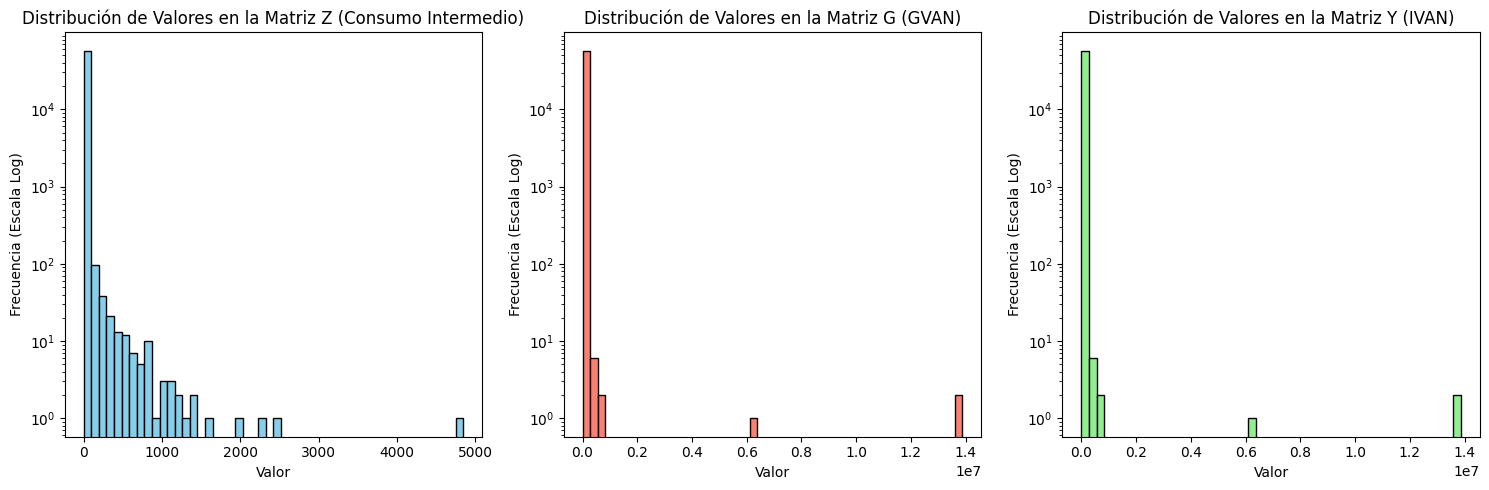

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta del archivo de Excel en Google Drive
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Cargar las matrices desde el archivo de Excel, con primera fila y columna como etiquetas de sectores
Intermediate_Consumption_Z = pd.read_excel(file_path, sheet_name='Intermediate_Consumption_Z', index_col=0, header=0)
G_df = pd.read_excel(file_path, sheet_name='GVAN Matrix (G)', index_col=0, header=0)
Y_df = pd.read_excel(file_path, sheet_name='IVAN Matrix (Y)', index_col=0, header=0)

# Aplanar cada matriz para obtener todos los valores en una sola lista para la visualización
values_Z = Intermediate_Consumption_Z.values.flatten()
values_G = G_df.values.flatten()
values_Y = Y_df.values.flatten()

# Crear histogramas para la distribución de valores en cada matriz
plt.figure(figsize=(15, 5))

# Histograma para la matriz Z (Consumo Intermedio)
plt.subplot(1, 3, 1)
plt.hist(values_Z, bins=50, color='skyblue', edgecolor='black', log=True)
plt.title('Distribución de Valores en la Matriz Z (Consumo Intermedio)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia (Escala Log)')

# Histograma para la matriz G (GVAN)
plt.subplot(1, 3, 2)
plt.hist(values_G, bins=50, color='salmon', edgecolor='black', log=True)
plt.title('Distribución de Valores en la Matriz G (GVAN)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia (Escala Log)')

# Histograma para la matriz Y (IVAN)
plt.subplot(1, 3, 3)
plt.hist(values_Y, bins=50, color='lightgreen', edgecolor='black', log=True)
plt.title('Distribución de Valores en la Matriz Y (IVAN)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia (Escala Log)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [ ]:
# Verificar si todos los valores no nulos en la matriz Z son iguales
unique_values_Z = Intermediate_Consumption_Z.values[Intermediate_Consumption_Z.values != 0]
unique_values_Z = np.unique(unique_values_Z)
print("Unique non-zero values in Z:", unique_values_Z)

# Similar para G y Y
unique_values_G = G_df.values[G_df.values != 0]
unique_values_G = np.unique(unique_values_G)
unique_values_Y = Y_df.values[Y_df.values != 0]
unique_values_Y = np.unique(unique_values_Y)
print("Unique non-zero values in G:", unique_values_G)
print("Unique non-zero values in Y:", unique_values_Y)



Unique non-zero values in Z: [3.42633913e-20 3.74572714e-20 7.49145428e-20 ... 2.28974040e+03
 2.51725482e+03 4.84686269e+03]
Unique non-zero values in G: [4.11841849e-28 1.64736740e-27 6.57259109e-27 ... 6.22833978e+06
 1.37611713e+07 1.38721622e+07]
Unique non-zero values in Y: [4.11841849e-28 1.64736740e-27 6.57259109e-27 ... 6.22833978e+06
 1.37611713e+07 1.38721622e+07]


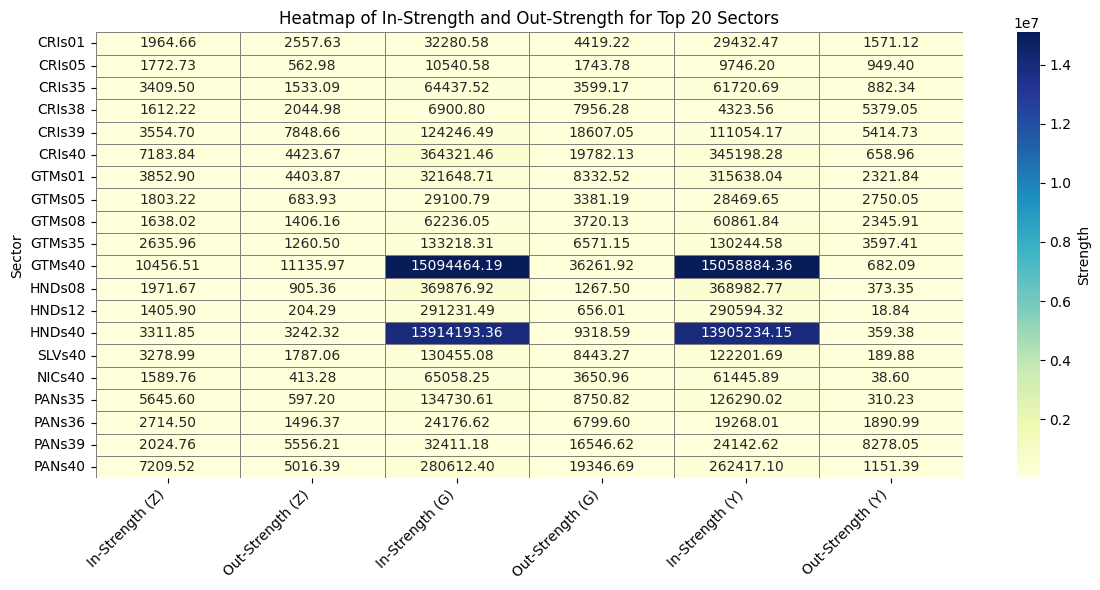

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el mapa de calor para in-strength y out-strength (solo para los sectores principales)
plt.figure(figsize=(12, 6))
sns.heatmap(
    strength_top_df[["In-Strength (Z)", "Out-Strength (Z)", "In-Strength (G)", "Out-Strength (G)", "In-Strength (Y)", "Out-Strength (Y)"]],
    annot=True,
    cmap="YlGnBu",  # Cambiar a una paleta más vibrante
    fmt=".2f",      # Mostrar con dos decimales
    cbar_kws={'label': 'Strength'},
    linewidths=0.5,  # Agregar líneas para mejorar la visualización de las celdas
    linecolor='gray'
)
plt.title("Heatmap of In-Strength and Out-Strength for Top 20 Sectors")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



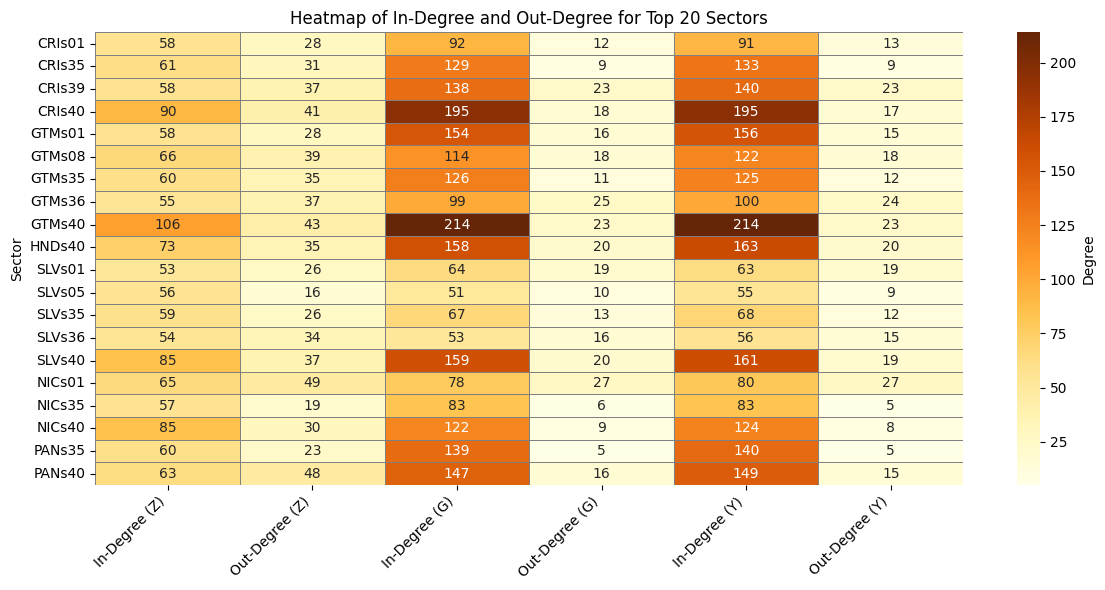

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ruta del archivo de Excel en Google Drive
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Cargar las matrices desde el archivo de Excel, con primera fila y columna como etiquetas de sectores
Intermediate_Consumption_Z = pd.read_excel(file_path, sheet_name='Intermediate_Consumption_Z', index_col=0, header=0)
G_df = pd.read_excel(file_path, sheet_name='GVAN Matrix (G)', index_col=0, header=0)
Y_df = pd.read_excel(file_path, sheet_name='IVAN Matrix (Y)', index_col=0, header=0)

# Definir el umbral basado en el percentil 90 para cada matriz
threshold_Z = np.percentile(Intermediate_Consumption_Z.values, 90)
threshold_G = np.percentile(G_df.values, 90)
threshold_Y = np.percentile(Y_df.values, 90)

# Crear versiones binarias de las matrices para el cálculo de degree usando el umbral basado en percentil
Z_binary = (Intermediate_Consumption_Z > threshold_Z).astype(int)
G_binary = (G_df > threshold_G).astype(int)
Y_binary = (Y_df > threshold_Y).astype(int)

# Calcular el in-degree y out-degree utilizando las matrices binarias
# Matriz Z
in_degree_Z = Z_binary.sum(axis=0)  # Conteo de conexiones entrantes
out_degree_Z = Z_binary.sum(axis=1)  # Conteo de conexiones salientes

# Matriz G (GVAN)
in_degree_G = G_binary.sum(axis=0)  # Conteo de conexiones entrantes
out_degree_G = G_binary.sum(axis=1)  # Conteo de conexiones salientes

# Matriz Y (IVAN)
in_degree_Y = Y_binary.sum(axis=0)  # Conteo de conexiones entrantes
out_degree_Y = Y_binary.sum(axis=1)  # Conteo de conexiones salientes

# Crear DataFrame para los resultados de degree
degree_df = pd.DataFrame({
    "Sector": Intermediate_Consumption_Z.index,
    "In-Degree (Z)": in_degree_Z.values,
    "Out-Degree (Z)": out_degree_Z.values,
    "In-Degree (G)": in_degree_G.values,
    "Out-Degree (G)": out_degree_G.values,
    "In-Degree (Y)": in_degree_Y.values,
    "Out-Degree (Y)": out_degree_Y.values
})

# Seleccionar los 20 sectores principales en función del in-degree en la matriz Z
top_sectors_degree = degree_df.nlargest(20, "In-Degree (Z)")["Sector"]

# Filtrar el DataFrame de degree para estos sectores principales
degree_top_df = degree_df[degree_df["Sector"].isin(top_sectors_degree)].set_index("Sector")

# Crear el mapa de calor para in-degree y out-degree (solo para los sectores principales)
plt.figure(figsize=(12, 6))
sns.heatmap(
    degree_top_df[["In-Degree (Z)", "Out-Degree (Z)", "In-Degree (G)", "Out-Degree (G)", "In-Degree (Y)", "Out-Degree (Y)"]],
    annot=True,
    cmap="YlOrBr",  # Paleta vibrante para resaltar los valores de degree
    fmt="g",        # Formato para enteros
    cbar_kws={'label': 'Degree'},
    linewidths=0.5, # Líneas para mejorar la distinción entre celdas
    linecolor='gray'
)
plt.title("Heatmap of In-Degree and Out-Degree for Top 20 Sectors")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx

# Ruta del archivo de Excel en Google Drive
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Cargar la matriz Y (IVAN Matrix) con primera fila y columna como etiquetas de sectores
Y_df = pd.read_excel(file_path, sheet_name='IVAN Matrix (Y)', index_col=0, header=0)

# Crear el grafo dirigido y ponderado desde la matriz Y
G_Y = nx.from_numpy_array(Y_df.values, create_using=nx.DiGraph)

# Asignar los nombres de los sectores como etiquetas de los nodos
labels = {i: sector for i, sector in enumerate(Y_df.index)}
nx.set_node_attributes(G_Y, labels, "sector")

# Calcular los potenciales de Helmholtz-Hodge
# Inicializamos los potenciales como la suma de los pesos entrantes menos los salientes
potentials = {node: sum(data['weight'] for _, _, data in G_Y.in_edges(node, data=True)) -
                     sum(data['weight'] for _, _, data in G_Y.out_edges(node, data=True))
              for node in G_Y.nodes()}

# Añadir los potenciales al grafo como un atributo
nx.set_node_attributes(G_Y, potentials, "potential")

# Calcular los flujos de Helmholtz-Hodge
potential_flows = {}
circular_flows = {}

for i, j, data in G_Y.edges(data=True):
    # Peso del enlace entre i y j
    wij = data['weight']

    # Calcular flujo potencial
    phi_i = potentials[i]
    phi_j = potentials[j]
    potential_flow = wij * (phi_i - phi_j)
    potential_flows[(i, j)] = potential_flow

    # Calcular flujo circular como la diferencia entre flujo total y flujo potencial
    circular_flow = wij - potential_flow
    circular_flows[(i, j)] = circular_flow

# Calcular el índice de integración económica en valor agregado (E) usando el flujo circular
total_circular_flow = sum(circular_flows[(i, j)] for (i, j) in circular_flows)
total_flow = Y_df.values.sum()
E = total_circular_flow / total_flow if total_flow != 0 else 0

print(f"Índice de Integración Económica en Valor Agregado (E): {E}")

# Crear DataFrames para los resultados de flujos potenciales y circulares
potential_flows_df = pd.DataFrame(list(potential_flows.items()), columns=["Edge", "Potential Flow"])
circular_flows_df = pd.DataFrame(list(circular_flows.items()), columns=["Edge", "Circular Flow"])

# Guardar los resultados en nuevas hojas del archivo de Excel
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    potential_flows_df.to_excel(writer, sheet_name="Potential Flows by Edge", index=False)
    circular_flows_df.to_excel(writer, sheet_name="Circular Flows by Edge", index=False)

print("Descomposición de Helmholtz-Hodge completada y guardada en el archivo de Excel.")


Índice de Integración Económica en Valor Agregado (E): 30900814.21730823
Descomposición de Helmholtz-Hodge completada y guardada en el archivo de Excel.


In [ ]:
import pandas as pd

# Cargar el archivo de Excel con los flujos de descomposición de Helmholtz-Hodge
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
flows_df = pd.read_excel(file_path, sheet_name="Potential Flows by Edge")  # Ajusta el nombre de la hoja si es necesario

# Crear el mapeo de índices a nombres de sectores
sector_df = pd.read_excel(file_path, sheet_name="Intermediate_Consumption_Z", index_col=0)  # Ajusta el nombre de la hoja si es necesario
index_to_sector = {index: name for index, name in enumerate(sector_df.index)}

# Reemplazar los índices en la columna 'Edge' con nombres de sectores
flows_df[['Node1', 'Node2']] = flows_df['Edge'].str.extract(r'\((\d+), (\d+)\)').astype(int)
flows_df['Node1'] = flows_df['Node1'].map(index_to_sector)
flows_df['Node2'] = flows_df['Node2'].map(index_to_sector)

# Crear una columna 'Edge' con los nombres de los sectores en lugar de los números
flows_df['Edge'] = '(' + flows_df['Node1'] + ', ' + flows_df['Node2'] + ')'

# Eliminar las columnas auxiliares si no son necesarias
flows_df = flows_df[['Edge', 'Potential Flow']]  # Mantener solo las columnas relevantes

# Guardar el DataFrame actualizado en una nueva hoja en el archivo de Excel
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    flows_df.to_excel(writer, sheet_name="Potential Flows with Sectors", index=False)

print("El archivo de Excel ha sido actualizado con nombres de sectores en la columna 'Edge'.")





El archivo de Excel ha sido actualizado con nombres de sectores en la columna 'Edge'.


In [ ]:
import pandas as pd

# Ruta del archivo de Excel
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Cargar el archivo de Excel con los flujos circulares
circular_flows_df = pd.read_excel(file_path, sheet_name="Circular Flows by Edge")  # Ajusta el nombre de la hoja si es necesario

# Crear el mapeo de índices a nombres de sectores
sector_df = pd.read_excel(file_path, sheet_name="Intermediate_Consumption_Z", index_col=0)  # Ajusta el nombre de la hoja si es necesario
index_to_sector = {index: name for index, name in enumerate(sector_df.index)}

# Reemplazar los índices en la columna 'Edge' con nombres de sectores
circular_flows_df[['Node1', 'Node2']] = circular_flows_df['Edge'].str.extract(r'\((\d+), (\d+)\)').astype(int)
circular_flows_df['Node1'] = circular_flows_df['Node1'].map(index_to_sector)
circular_flows_df['Node2'] = circular_flows_df['Node2'].map(index_to_sector)

# Crear una columna 'Edge' con los nombres de los sectores en lugar de los números
circular_flows_df['Edge'] = '(' + circular_flows_df['Node1'] + ', ' + circular_flows_df['Node2'] + ')'

# Eliminar las columnas auxiliares si no son necesarias
circular_flows_df = circular_flows_df[['Edge', 'Circular Flow']]  # Mantener solo las columnas relevantes

# Guardar el DataFrame actualizado en una nueva hoja en el archivo de Excel
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    circular_flows_df.to_excel(writer, sheet_name="Circular Flows with Sectors", index=False)

print("El archivo de Excel ha sido actualizado con nombres de sectores en la columna 'Edge' para los flujos circulares.")


El archivo de Excel ha sido actualizado con nombres de sectores en la columna 'Edge' para los flujos circulares.


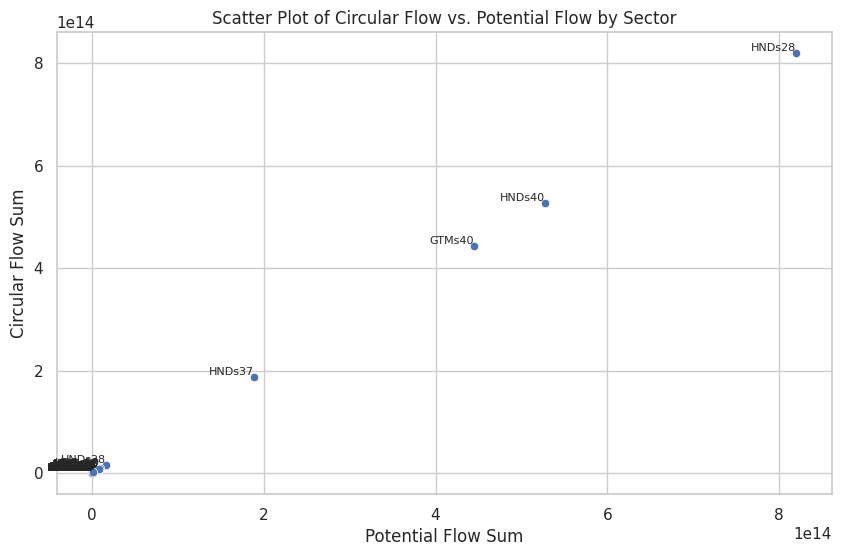

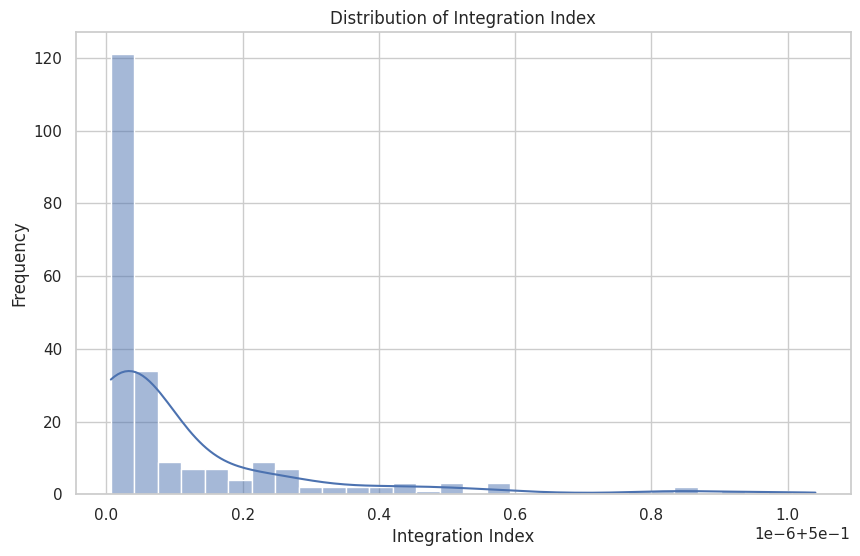

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos del archivo Excel
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"
integration_df = pd.read_excel(file_path, sheet_name="Integration Index by Sector")

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Gráfico de dispersión: Flujos Circulares vs. Flujos Potenciales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Potential Flow Sum', y='Circular Flow Sum', data=integration_df)
plt.title("Scatter Plot of Circular Flow vs. Potential Flow by Sector")
plt.xlabel("Potential Flow Sum")
plt.ylabel("Circular Flow Sum")

# Añadir etiquetas de los sectores
for i, row in integration_df.iterrows():
    plt.text(row['Potential Flow Sum'], row['Circular Flow Sum'], row['Sector'],
             fontsize=8, ha='right', va='bottom')

plt.show()

# Histograma de distribución del índice de integración
plt.figure(figsize=(10, 6))
sns.histplot(integration_df['Integration Index'], bins=30, kde=True)
plt.title("Distribution of Integration Index")
plt.xlabel("Integration Index")
plt.ylabel("Frequency")
plt.show()



In [ ]:
# Mostrar los primeros registros de la tabla con los datos del índice de integración
print(integration_df.head(10))  # Muestra las primeras 10 filas; puedes ajustar el número si deseas ver más o menos filas

# Para ver toda la tabla si es pequeña, puedes usar simplemente:
integration_df


   Sector  Circular Flow Sum  Potential Flow Sum  Total Flow Sum  \
0  CRIs01       1.873347e+11        1.873347e+11    3.746694e+11   
1  CRIs02       7.998934e+08        7.998905e+08    1.599784e+09   
2  CRIs04       1.506606e+09        1.506600e+09    3.013206e+09   
3  CRIs05       5.564010e+10        5.564009e+10    1.112802e+11   
4  CRIs06       1.189032e+10        1.189032e+10    2.378064e+10   
5  CRIs07       1.342576e+09        1.342575e+09    2.685151e+09   
6  CRIs08       2.649934e+10        2.649933e+10    5.299867e+10   
7  CRIs09       2.886498e+09        2.886496e+09    5.772994e+09   
8  CRIs10                NaN                 NaN             NaN   
9  CRIs11       9.920918e+08        9.920902e+08    1.984182e+09   

   Integration Index  
0           0.500000  
1           0.500001  
2           0.500001  
3           0.500000  
4           0.500000  
5           0.500000  
6           0.500000  
7           0.500000  
8                NaN  
9           0.500000 

,Sector,Circular Flow Sum,Potential Flow Sum,Total Flow Sum,Integration Index
0,CRIs01,1.873347e+11,1.873347e+11,3.746694e+11,0.500000
1,CRIs02,7.998934e+08,7.998905e+08,1.599784e+09,0.500001
2,CRIs04,1.506606e+09,1.506600e+09,3.013206e+09,0.500001
3,CRIs05,5.564010e+10,5.564009e+10,1.112802e+11,0.500000
4,CRIs06,1.189032e+10,1.189032e+10,2.378064e+10,0.500000
...,...,...,...,...,...
223,SLVs36,4.920427e+10,4.920427e+10,9.840854e+10,0.500000
224,SLVs37,4.157558e+10,4.157557e+10,8.315115e+10,0.500000
225,SLVs38,3.237554e+10,3.237553e+10,6.475107e+10,0.500000
226,SLVs39,7.695088e+10,7.695087e+10,1.539017e+11,0.500000


In [ ]:
import pandas as pd

# Ruta del archivo de Excel
file_path = "/content/drive/MyDrive/Thesis/thesis/Paper input output/data/real/CA IO table 2014 - real.xlsx"

# Cargar los flujos potenciales y circulares
potential_flows_df = pd.read_excel(file_path, sheet_name="Potential Flows with Sectors")
circular_flows_df = pd.read_excel(file_path, sheet_name="Circular Flows with Sectors")

# Separar los sectores de la columna 'Edge'
potential_flows_df[['Node1', 'Node2']] = potential_flows_df['Edge'].str.extract(r'\(([^,]+), ([^)]+)\)')
circular_flows_df[['Node1', 'Node2']] = circular_flows_df['Edge'].str.extract(r'\(([^,]+), ([^)]+)\)')

# Sumar los valores absolutos de los flujos por sector (como Node1 y Node2)
# Suma de flujos circulares por sector
circular_sum_by_sector = (
    circular_flows_df.groupby('Node1')['Circular Flow'].apply(lambda x: x.abs().sum()) +
    circular_flows_df.groupby('Node2')['Circular Flow'].apply(lambda x: x.abs().sum())
)

# Suma de flujos potenciales por sector
potential_sum_by_sector = (
    potential_flows_df.groupby('Node1')['Potential Flow'].apply(lambda x: x.abs().sum()) +
    potential_flows_df.groupby('Node2')['Potential Flow'].apply(lambda x: x.abs().sum())
)

# Suma total de flujos (potenciales + circulares) por sector
total_flow_by_sector = circular_sum_by_sector + potential_sum_by_sector

# Calcular el índice de integración por sector usando valores absolutos
integration_index = circular_sum_by_sector / total_flow_by_sector

# Crear un DataFrame para los resultados
integration_df = pd.DataFrame({
    'Sector': integration_index.index,
    'Circular Flow Sum': circular_sum_by_sector,
    'Potential Flow Sum': potential_sum_by_sector,
    'Total Flow Sum': total_flow_by_sector,
    'Integration Index': integration_index
}).reset_index(drop=True)

# Guardar el DataFrame en una nueva hoja en el archivo de Excel
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    integration_df.to_excel(writer, sheet_name="Integration Index by Sector", index=False)

print("El archivo de Excel ha sido actualizado con el índice de integración corregido por sector.")



El archivo de Excel ha sido actualizado con el índice de integración corregido por sector.
